Если запускаете из colab, то с помощью ячейки ниже можно скачать данные

In [ ]:
# from google.colab import files
# files.upload()

# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !kaggle datasets download -d amanagr/people-art-dataset
# !unzip people-art-dataset.zip

In [ ]:
# !pip install lightning
# !pip install aim==3.17.5
# !pip install xmltodict

## Задание: детекция людей на картинах (8 баллов + 3 дополнительных)

1. Скачайте датасет PeopleArt ([github](https://github.com/BathVisArtData/PeopleArt), [kaggle](https://www.kaggle.com/datasets/amanagr/people-art-dataset)), напишите `lightning.LightningDataModule` для работы с ним
2. Реализуйте `lightning.LightningModule` для обучения детектора.
3. Реализуйте расчёт и логирование метрик (mAP - обязательно, остальное - по желанию), можно использовать `torchmetrics` и любой понравившийся логгер (`tensorboard`, `aim`, `mlflow`, `wandb`, etc).
4. Реализуйте обучение модели с сохранением чекпоинта
5. Постарайтесь добиться mAP $\gt$ 0.3 Можно использовать предобученные модели из `torchvision`
6. В решении приложите к ноутбуку архив с логами и чекпоинтом модели

Критерии оценки:
1. (6 баллов) Реализованы модули для работы с данными и моделью и возможность запустить обучение и валидацию.
2. (2 балла) Удалось добиться $mAP > 0.3$

За что могут быть снижены баллы:
1. Ваш ноутбук падает с ошибкой - проверьте перед отправкой, что при перезагрузке кернела и последовательном исполнении ячеек всё запускается.
2. Неаккуратное оформление - без фанатизма, просто постарайтесь, чтобы не было огромных функций в 30+ строк без комментариев, переменных с именами в один символ, слишком много ячеек, где вы просто что-то отлаживаете без пояснений
3. Не приложены логи и чекпоинты - без них будет сложно понять, что у вас получилось

Советы:
- если вы сможете большую часть своего кода вынести в `.py` файлы, а в ноутбуке будете их импортировать - будет совсем хорошо, тогда ноутбук получится лаконичным и чистым.
- для автоматического форматирования ноутбуков есть полезный пакет `nbqa`, можно обработать финальную версию хотя бы так:
  ```bash
  nbqa isort peopleart_detection.ipynb
  nbqa black peopleart_detection.ipynb
  ```

In [3]:
import matplotlib.pyplot as plt
import requests
import torch
import torch.nn.functional as F
import torchvision
import xmltodict
from lightning import LightningDataModule, LightningModule, Trainer
from PIL import Image
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
from torchmetrics.detection import IntersectionOverUnion, MeanAveragePrecision
from torchvision import transforms
from torchvision.utils import draw_bounding_boxes


path_to_directory = './'  # сюда можно ввести пользовательский путь до директории
N_EPOCH = 20

### 1. Подготовка данных

Для того, чтобы можно было использовать модели из `torchvision.models.detection`, нужно обеспечить правильный формат данных.

`Dataloader` должен возвращать батчи вида `tuple[list[Tensor], list[dict[str, Tensor]]]`, то есть пару списков:
- с изображениями (в виде тензоров, могут быть любого размера)
- и соответствующей аннотацией (словари, где обязательно есть поля `boxes` и `labels`)

Пример батча - ниже в переменной `batch`

Для реализации модуля данных:
1. Реализуйте подкласс `torch.utils.data.Dataset`, где будет реализован парсинг аннотаций (они в XML, вам пригодится пакет `xmltodict`) и сбор данных в пары изображение-аннотация, причём аннотации уже должны быть приведены в нужный формат, как в примере ниже, а метод `__getitem__` должен возвращать `tuple[Tensor, dict[str, Tensor]]`
2. Реализуйте подкласс `lightning.LightningDataModule`, который будет создавать датасеты для подвыборок (train/val/test) и загрузчики данных для них. Для упаковки данных в батчи вам нужно будет определить аргумент `collate_fn` для `torch.utils.data.DataLoader`, иначе код будет падать при попытке сложить изображения разного размера.
3. Примечание: если вы захотите описать свою модель без использования архитектур из `torchvision`, то на этапе упаковки в батчи было бы логично привести изображения к единому размеру, например сделать размер большей стороны равным $416$, а затем добавить zero padding для того, чтобы итоговый размер изображения был равен $416 \times 416$. Это позволит обрабатывать батч параллельно на GPU. При этом аннотацию нужно изменить согласованным образом! В `albumentations` есть нужные трансформации, которые работают одновременно с изображением и разметкой, поищите их. При работе с детекторами из `torchvision` эти операции обычно делаются где-то внутри класса модели. Сможете найти их, например, для `SSD`?

Пример данных: что-то такое может храниться внутри вашего класса для датасета, но сами изображения лучше читать с диска внутри метода `__getitem__`

Функция ниже производит парсинг картинок и аннотаций


In [4]:
def parse_data(stage: str, line):
    masterpiece_picture = None
    masterpiece_annotation = None
    data = None
    boxes = []
    masterpiece_path = line.split()[0]
    label = line.split(' ')[1]
    masterpiece_picture = Image.open(path_to_directory + 'PeopleArt-master/JPEGImages/' + masterpiece_path)
    if label == '1':
        masterpiece_annotation = xmltodict.parse(open(path_to_directory + 'PeopleArt-master/Annotations/' + masterpiece_path + '.xml').read())['annotation']['object']
        if type(masterpiece_annotation) == dict:
            boxes.append([int(masterpiece_annotation['bndbox']['xmin']),
                        int(masterpiece_annotation['bndbox']['ymin']),
                        int(masterpiece_annotation['bndbox']['xmax']),
                        int(masterpiece_annotation['bndbox']['ymax'])])
        else:
            for object in masterpiece_annotation:
                boxes.append([int(object['bndbox']['xmin']),
                            int(object['bndbox']['ymin']),
                            int(object['bndbox']['xmax']),
                            int(object['bndbox']['ymax'])])
        if len(boxes) == 0:
            boxes.append(torch.tensor([]))
        data = (transforms.ToTensor()(masterpiece_picture),
                    {'boxes': torch.tensor(boxes), 'labels':torch.tensor([1]*len(boxes))})
    else:
        data = (transforms.ToTensor()(masterpiece_picture),
                    {'boxes': torch.tensor([]), 'labels':torch.tensor([])})
    return data



In [5]:
class Our_dataset(Dataset):
    def __init__(self, stage: str) -> None:
        super().__init__()
        self.stage = stage
        self.items = []
        for item in open(path_to_directory + 'PeopleArt-master/Annotations/person_' + stage + '.txt').read().split('\n')[:-1]:
            if item.split()[1] != '-1' or stage == 'test' or stage == 'val': # мы не хотим обучаться на картинах без людей
                self.items.append(item)

    def __getitem__(self, index):
        return parse_data(self.stage, self.items[index])

    def __len__(self) -> int:
        return len(self.items)

In [6]:
from lightning.pytorch.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS


class Datamodule(LightningDataModule):
    def __init__(
        self,
        batch_size: int,
    ) -> None:
        super().__init__()
        self.batch_size = batch_size

    @property
    def collate_fn(self):
        return lambda batch: tuple(zip(*batch))

    def setup(self, stage: str) -> None:
        if stage in ("fit", "validate"):
            self.val_dataset = Our_dataset('val')
        if stage == "fit":
            self.train_dataset = Our_dataset('train')
        if stage == 'test':
            self.test_dataset = Our_dataset('test')

    def train_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            collate_fn=self.collate_fn,
        )

    def val_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=self.collate_fn,
        )

    def test_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=self.collate_fn,
        )

### Модели из `torchvision`

Разберём для примера `SSD`, вы можете взять любую другую модель, в том числе написать всё самостоятельно

In [7]:
from torchvision.models.detection import ssdlite320_mobilenet_v3_large, SSDLite320_MobileNet_V3_Large_Weights

# создадим модель с весами COCO
weights = SSDLite320_MobileNet_V3_Large_Weights.COCO_V1
ssd = ssdlite320_mobilenet_v3_large(weights=weights)


Downloading: "https://download.pytorch.org/models/ssdlite320_mobilenet_v3_large_coco-a79551df.pth" to /root/.cache/torch/hub/checkpoints/ssdlite320_mobilenet_v3_large_coco-a79551df.pth
100%|██████████| 13.4M/13.4M [00:00<00:00, 108MB/s] 


### Вывод модели в режиме обучения

#### Мы хотим брать только те bounding box, вероятность которых довольно большая

In [15]:
def get_good_predicts(predicts):
    for predict in predicts:
        indexes = [i for i in range(len(predict['scores'])) if predict['scores'][i] > 0.15]
        predict['boxes'] = predict['boxes'][indexes]
        predict['scores'] = predict['scores'][indexes]
        predict['labels'] = predict['labels'][indexes]

#### Наша модель, обернутая в LightningModule


In [8]:
class Lit(LightningModule):
    def __init__(self, learning_rate: float) -> None:
        super().__init__()
        self.save_hyperparameters()
        self.weights = SSDLite320_MobileNet_V3_Large_Weights.COCO_V1
        self.model = ssdlite320_mobilenet_v3_large(weights=self.weights)
        self.learning_rate = learning_rate

    def forward(self, batch: tuple[Tensor, Tensor]):
        self.model.eval()
        predicts = self.model(batch[0])
        get_good_predicts(predicts)
        return predicts

    def training_step(
        self, batch: tuple[list[Tensor], list[dict[str, Tensor]]], batch_idx: int
    ):
        self.model.train()

        model_loss = self.model(batch[0], batch[1])
        loss = 0.5 * model_loss['bbox_regression'] + 0.5 * model_loss['classification']
        self.log("train_loss", loss, on_epoch=True, on_step=False)

        return loss

    def validation_step(
        self, batch: tuple[Tensor, Tensor], batch_idx: int
    ):

        predicts = self.model(batch[0])
        get_good_predicts(predicts)
        map = MeanAveragePrecision(iou_type="bbox")
        map.update(predicts, batch[1])
        self.log('MAP', map.compute()['map'])

        return {
            "loss": map.compute()['map'],
            "preds": predicts,
        }

    def test_step(self, batch: tuple[Tensor, Tensor]) :
        predicts = self.model(batch[0])
        get_good_predicts(predicts)
        map = MeanAveragePrecision(iou_type="bbox")
        map.update(predicts, batch[1])
        self.log('MAP', map.compute()['map'])
        return predicts

    def predict_step(self, batch, batch_idx: int):
        return self(batch)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        return {
            "optimizer": optimizer,
            "lr_scheduler": torch.optim.lr_scheduler.MultiStepLR(
                optimizer, milestones=[5, 10, 15]
            )
        }

#### Запуск логгера из *колаба*

In [ ]:
from aim.pytorch_lightning import AimLogger

logger = AimLogger(experiment="people art detection")
%load_ext aim
%aim up

#### Настройка чекпоинтов и ранней остановки

In [13]:
from datetime import datetime

from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    ModelCheckpoint(
        dirpath=f"logs/checkpoints/{str(datetime.now())}",
        filename="{epoch}",
        monitor="MAP",
        mode="min",
        save_top_k=2,
        save_last=True,
    ),
    EarlyStopping(
        monitor="train_loss",
        mode="min",
        patience=5,
    )
    ]

#### Создание и запуск модели

In [16]:
lit_module = Lit(0.0004)
datamodule = Datamodule(batch_size=64)

In [17]:
trainer = Trainer(
    accelerator="gpu",
    max_epochs=N_EPOCH,
    limit_train_batches=100,
    limit_val_batches=100,
    logger=logger,
    callbacks=callbacks,
)
trainer.fit(
    model=lit_module,
    datamodule=datamodule,
)

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type | Params
-------------------------------
0 | model | SSD  | 3.4 M 
-------------------------------
3.4 M     Trainable params
0         Non-trainable params
3.4 M     Total params
13.760    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type | Param

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


### Проверим модель на тестовых данных

In [18]:
trainer.test(lit_module, datamodule=datamodule)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            MAP            │    0.31519410014152527    │
└───────────────────────────┴───────────────────────────┘

[{'MAP': 0.31519410014152527}]

### Отрисуем предсказания

In [19]:
test_datamodule = Datamodule(4)
test_datamodule.setup('test')
test_dataloader = test_datamodule.test_dataloader()
batch = enumerate(test_dataloader)


In [20]:
test_datamodule = Datamodule(4)
test_datamodule.setup('test')
test_dataloader = test_datamodule.test_dataloader()
a = enumerate(test_dataloader)
next(a)
batch = next(a)[1]
preds = lit_module(batch)
images = [torchvision.transforms.ToPILImage()(batch[0][i]) for i in range(len(batch[0]))]
our_batch = [(images[i], preds[i]) for i in range(len(images))]


In [21]:
get_good_predicts(preds)

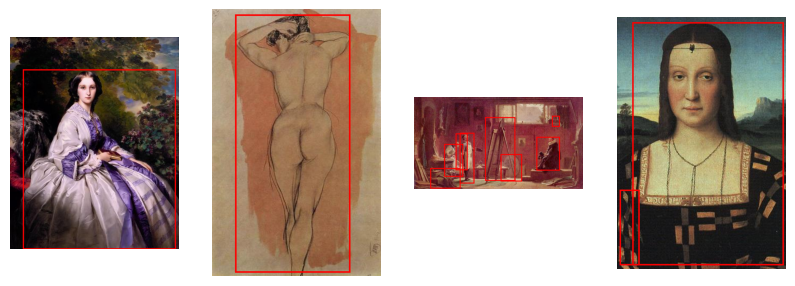

In [23]:
fig, axes = plt.subplots(ncols=len(our_batch), figsize=(10, 7))
for sample, ax in zip(our_batch, axes):
    # нарисуем рамки
    detection = draw_bounding_boxes(
        transforms.Compose([transforms.ToTensor(), transforms.ConvertImageDtype(torch.uint8)])(sample[0]),
        boxes=sample[1]["boxes"],
        width=3,
        font="LiberationSans-Bold",
        font_size=15,
        colors="red",
    )
    detection: Image.Image = torchvision.transforms.ToPILImage()(detection)
    ax.imshow(detection)
    ax.set_axis_off()

В целом, если человек занимает бОльшую часть картины, то модель находит его весьма неплохо